In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
from munkres import Munkres

#from jupyterthemes import jtplot
#jtplot.style()
#jtplot.reset()
#plt.style.use("dark_background")

**I - Data generation and manipulation**

In this practical session we will use two datasets :
- a first simple one, to understand how the SPA iterations work ;
- a real hyperspectral one, called urban.
Urban is one of the most widely used hyperspectral data used for hyperspectral unmixing studies. There are 307 x 307 pixels, each of which corresponds to a 2 x 2 m2 area. There are 210 wavelengths ranging from 400 nm  to 2500 nm, resulting in a spectral resolution of 10 nm. After the channels 1--4, 76, 87, 101--111, 136--153 and 198--210 are removed (due to dense water vapor and atmospheric effects), we obtain 162  channels.
Interestingly enough, a ground truth have been established. The one we will use contains 6 endmembers (i.e. sources).

**1) Simple dataset**

We propose to generate a very simple dataset, for visual purposes, as follows:
- the mixing matrix **A** will be a m x n matrix with its coefficients generated randomly in [0,10]. When you obtain such a realisation, verify that **A** is not too badly conditioned.
- the source matrix **S** will be a n x t matrix with random coefficients in [0,1] but will be scalled so that the l1-norm of each of its columns sum to 1.
- There will be no noise.

Si la matrice est mal conditionnée, de petites erreurs d'approximations peuvent aboutir à des résultats finaux très différents.

Conditionnement de A = 16.795426682754115


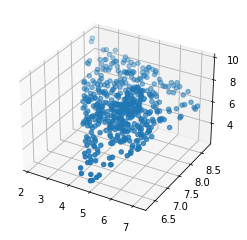

In [2]:
# TO DO : generate A according to the above description.
# TO DO : compute the condition number of A. What would be the issue with an ill-conditioned mixing matrix?
# TO DO : generate S according to the above conditions.
# TO DO : generate X with a linear mixing

n = 3
m = 3
t = 500

A_toy = np.random.random(size=(m,n))*10
S_toy = np.random.random(size=(n,t))
S_toy = S_toy / np.sum(S_toy,axis=0)
X_toy = A_toy@S_toy 

print("Conditionnement de A =",np.linalg.cond(A_toy))

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_toy[0,:],X_toy[1,:],X_toy[2,:])
plt.show()

**2) Real hyperspectral data set** 

First, upload in your working environment the two files Urban.mat and end6_groundTruth.mat, which can be found at https://partage.imt.fr/index.php/s/F7cRFrAre5neA9o

Here, we will use the "Urban" dataset:
- The data matrix **X = AS + N**, which has been acquired by a true sensor ;
- The groundtruth **S_gt**, which corresponds to the "true" abundances (such groundtruth can for instance be found by on earth geological inquiries). Note that having access to **S_gt** is exceptional: for most other datasets, it would be unknown.

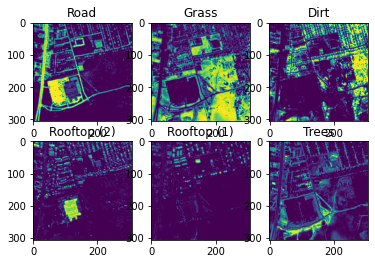

In [3]:
data = sci.loadmat('Urban.mat')
X = data['X']
X = X.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations

gt = sci.loadmat('end6_groundTruth.mat')
abundances = gt['A']

nCol = 307
nRow = 307

plt.figure()
#TO DO : try to interpret the abundances that you see. Hint : the 6 sources are usually called ['Grass','Road','Rooftop (2)','Dirt','Trees','Rooftop (1)']. Associate a name to each endmember.
names = ['Road','Grass','Dirt','Rooftop (2)','Rooftop (1)','Trees']
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))
    
    plt.title(names[ii])
plt.show()

In [4]:
S_gt = abundances
A_gt = gt['M'] # We do have it actually

- TO DO : is the near separable (aka pure pixel) assumption fulfilled on this dataset? Explain why.

Si on affiche S on constate qu'il n'y pas forcémenent de points sur tous les axes, c'est à dire que l'on ne pourra pas trouver, à un facteur d'échelle près, les vecteurs unités de $\mathbb{R}^6$ parmi les colonnes de S. Donc les données ne sont pas presque séparables. Pour que les données soient vraiment séparables il faudrait qu'il existe un pixel avec uniquement de la route, du toit etc, ce qui n'est pas envisageable avec une résolution 2mx2m.

- TO DO : we have access to the abundance **S_gt** groundtruth but not to the endmembers **A_gt**. Use your above answer to the to explain how the following code finds the endmembers. 
In particular, explain the use of the mean function (adding some plots to your report might be beneficial here).

On se base sur l'idée de presque séparabilité. On récupère d'abord en utilisant l'abondance les pixels purs pour chaque source. Puis on en déduit les colonnes de X qui forment quasiment la matrice A. Enfin on moyenne sur les pixels purs pour obtenir une unique valeur pour chaque channel en sachant que les pixels que l'on a sont purs. 

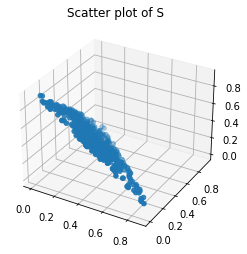

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(S_toy[0,:],S_toy[1,:],S_toy[2,:])
ax.set_title("Scatter plot of S")
plt.show()

(6, 94249) (162, 357)


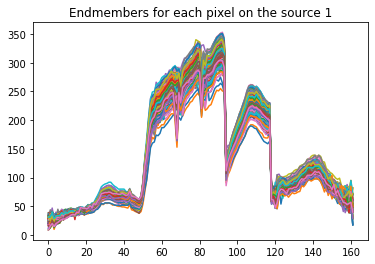

In [6]:
endmembers= np.zeros((162,6))

idx_source = 1

ind = np.where(abundances[idx_source] > 0.999)[0]
allPP = X[:,ind]
print(abundances.shape,allPP.shape)
plt.plot(allPP)
plt.title("Endmembers for each pixel on the source "+str(idx_source))
plt.show()

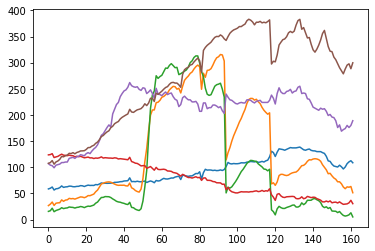

In [7]:
endmembers= np.zeros((162,6))

for ii in range(6): 
    ind = np.where(abundances[ii] > 0.999)[0]
    allPP = X[:,ind]
    endmembers[:,ii] = np.mean(allPP,axis=1)


plt.figure(),plt.plot(endmembers)
plt.show()

**II - Near separable algorithm**

We will here implement the SPA (greedy) near-separable NMF algorithm and look at its practical efficiency.

1) Recall what near-separable NMF is.

La presque séparabilité est lorsque que l'on a $ X = X(:, \mathcal{K})S^* + N$ avec $\forall j, ||n_j|| \le \epsilon$ et $\mathcal{K}$ un sous ensemble de colonnes.

2) Implement the SPA algorithm

In [8]:
def simpleSPA(Xin,r,optDisp=False): # TO DO. 
    
    R = Xin.copy()    
    
    K = np.zeros(r)
    
    for ii in range(r):
        
        if optDisp  :
            fig = plt.figure()
            ax = fig.add_subplot(111,projection='3d')
            ax.scatter(R[0,:],R[1,:],R[2,:])
            ax.set_title("Scatter plot of the residual for r = "+str(ii))
            plt.show()            
        
        print('Max residual %s'%np.max(R))
        
        p = np.argmax(np.linalg.norm(R,axis=0))
        
        K[ii] = p
        
        r_p = R[:,p].reshape(-1,1)
        
        R = (np.identity(R.shape[0]) - r_p@r_p.T / np.linalg.norm(r_p)**2) @ R
        
         
    if optDisp  :
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
        ax.scatter(R[0,:],R[1,:],R[2,:])
        ax.set_title("Scatter plot of the residual for r = "+str(r))
        plt.show()    
        
    return K.astype(int)

3) Launch the SPA algorithm on the toy example.

Plot the residual at each iteration of SPA. 

How many sources can you at most extract ? Why ?

On va être limitée sur le nombre de source par la taille de A. A va faire que les données vont évoluer dans un espace au plus de la taille du nombre de colonnes de A ce qui va empecher de déterminer plus de sources. Aussi plus on projette les données dans la SPA, plus les résidus sont petits et donc plus ils sont suspectibles d'être imprécis ce qui va aussi impacter la détermination des sources. 

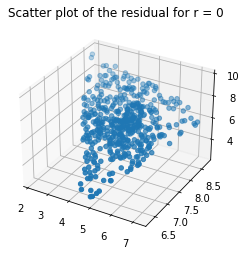

Max residual 9.771058717154055


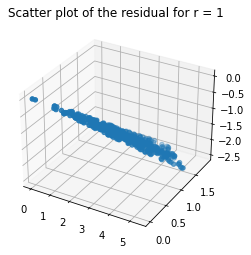

Max residual 5.373672600648122


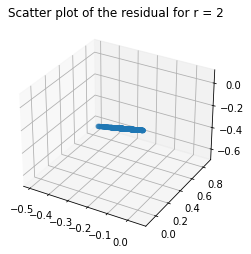

Max residual 0.8656924898608656


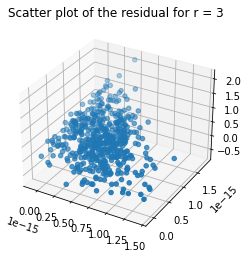

K_SPA_toy = array([322, 124, 492])


In [9]:
K_SPA_toy = simpleSPA(X_toy,3,optDisp = True)
print(f"{K_SPA_toy = }")

**4)** The code below enables to compute a separation metric to measure the separation accuracy of the BSS algorithms. 

Use the evalCriterion function to assess the quality of SPA on the real dataset.

Plot the endmembers found by your algorithm. How good are they?

Globalement le résultat est assez satisfaisant. La similarité est assez élevée et pour chaque source les courbes sont assez similaires. Après si on regarde plus précisement on constate tout de même des différences assez notables qui font que la détermination de S_est est moins fiable.

In [10]:
def norm_col(A):
    An = A.copy()
    type(An)
    for ii in range(np.shape(An)[1]):
        An[:,ii] = An[:,ii]/np.sqrt(np.sum(An[:,ii]**2));
    
    return An




def correctPerm(W0_en,W_en):
    # [WPerm,Jperm,err] = correctPerm(W0,W)
    # Correct the permutation so that W becomes the closest to W0.
    
    W0 = W0_en.copy()
    W = W_en.copy()
    
    W0 = norm_col(W0)
    W = norm_col(W)
    
    costmat = -W0.T@W; # Avec Munkres, il faut bien un -

    
    m = Munkres()
    Jperm = m.compute(costmat.tolist())
    
    WPerm = np.zeros(np.shape(W0))
    indPerm = np.zeros(np.shape(W0_en)[1])
    
    for ii in range(W0_en.shape[1]):
        WPerm[:,ii] = W_en[:,Jperm[ii][1]]
        indPerm[ii] = Jperm[ii][1]
        
    return WPerm,indPerm.astype(int)




def evalCriterion(W0_en,W_en):
    # W0 : true mixing matrix
    # W : estimated mixing matrix
    #
    # maxAngle : cosine of the maximum angle between the columns of W0 and W
    
    W0 = W0_en.copy()
    W = W_en.copy()
    
    W,indPerm = correctPerm(W0,W);
    
    W0 = norm_col(W0_en)
    W = norm_col(W)

    diff = W0.T@W;
    
    return np.mean(np.diag(diff));

Max residual 1000.0
Max residual 603.417343707026
Max residual 503.62039752697126
Max residual 202.62882898875844
Max residual 180.7841329331174
Max residual 160.99372330966378
Eval criterion 0.9149174369799745


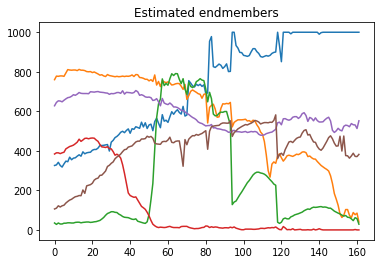

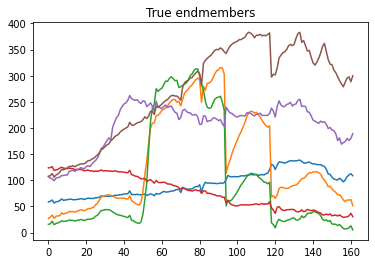

In [11]:
K_spa = simpleSPA(X,6,optDisp = False)
A_est = X[:,K_spa]
print("Eval criterion",evalCriterion(endmembers,A_est))
plt.plot(A_est)
plt.title("Estimated endmembers")
plt.show()

plt.plot(endmembers)
plt.title("True endmembers")
plt.show()

**5)** (Bonus) The SPA algorithm gives you an estimation of the mixing matrix. Code an ISTA algorithm to obtain the corresponding sources (abundances). Plot them.

In [12]:
def prox_l1(S_est, thrd):
    
    S_est[S_est>thrd] -=  thrd
    S_est[S_est<-thrd] += thrd
    S_est[abs(S_est)<=thrd] = 0

    return S_est

def ISTA(X,A = np.eye(2),n=2,lamb=1,nbIt = 100):
    
    k=0
    gamma = 0.9/ np.linalg.norm(A.T@A)

    S_est = np.random.random((n, X.shape[1]))
    
    while k< nbIt :
        if k%25==0 : print(k,end=', ')
        S_est = prox_l1(S_est + gamma * A.T @ (X-A@S_est), gamma*lamb)
        
        k += 1
    return S_est

In [13]:
S_est = ISTA(X,A_est,n=6,nbIt=500,lamb=1000)

0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 

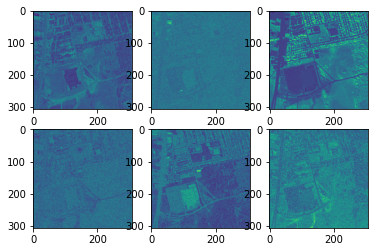

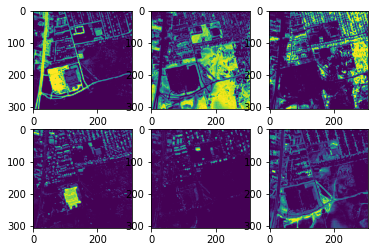

In [14]:
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_est[ii,:].reshape(nCol,nRow))

plt.show()   
    
plt.figure()
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_gt[ii,:].reshape(nCol,nRow))
    
plt.show()

**III - PLAIN NMF**

In this part we use the PALM algorithm to perform plain NMF. Of course, if you already coded the PALM algorihtm with sparsity constriant in the previous TP, you can just adapt it.

This optimization scheme is simple but can provide decent separation results.

**1)** Write the cost function of plain NMF.

$$
\frac{1}{2}||X-AS||^2 + \mathbb{1}_{\ge 0  }(S) + \mathbb{1}_{\ge 0  }(A)
$$

**2)** Implement the proximal operator of the nonnegativity constraint.

In [15]:
def prox_positive(S): # TO DO
    S[S<0] = 0
    return S

**3)** Implement the PALM algorithm to solve the plain NMF problem.

In [16]:
def PALM(X,n=2,nbIt = 100,Ainit=None,Sinit=None): # TO DO : reutiliser le PALM du TP precedent et l'adapter
    
    if Ainit is None :
        A_est = np.random.rand(X.shape[0], n)
    else :
        A_est = Ainit
    if Sinit is None : 
        S_est = np.random.rand(n, X.shape[1])
    else:
        S_est = Sinit
    
    k=0
    
    while k < nbIt:
        if k%25 == 0 : print(k,end=', ')        
        gamma = 0.9/np.linalg.norm(A_est@(A_est.T))
        eta = 0.9/np.linalg.norm(S_est@(S_est.T))
        
        S_est = prox_positive(S_est + gamma * A_est.T @ (X-A_est@S_est))
        A_est = prox_positive( A_est + eta * (X-A_est@S_est)@S_est.T)
        
        k+=1
        
    return A_est,S_est

**4)** 
Launch the PALM algorithm on the real hyperspectral dataset. 

Can you find of a better initialization than the random one ?

Compare your result, both qualitatively and quantitatively, with the SPA algorithm. Explain the differences.

Plot the abundances.

On peut utiliser les résultats calculés précédemment avec la SPA (et si on l'a fait l'ISTA) comme initialisation. On constate qu'on obtient des moins bons résultats sur certains points. La similarité sur la matrice de mélange est plus faible et l'estimation de l'abondances n'est bonne que pour quelques sources.

In [17]:
# CORRECTION
A_est,S_est = PALM(X,n=6,nbIt = 1000,Ainit=A_est,Sinit=S_est) # TO DO: modify the initialization

0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 

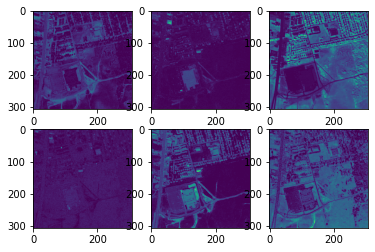

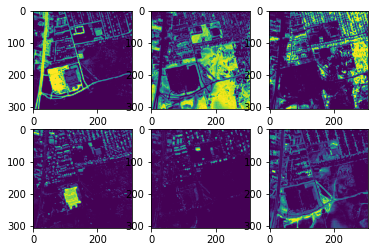

In [18]:
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_est[ii,:].reshape(nCol,nRow))

plt.show()   
    
plt.figure()
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_gt[ii,:].reshape(nCol,nRow))
    
plt.show()

Eval criterion for A 0.8891644679244548


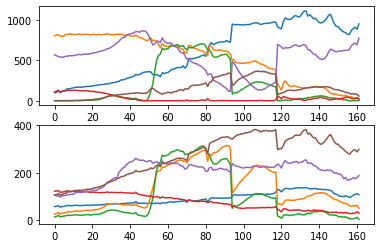

In [19]:
print('Eval criterion for A',evalCriterion(endmembers,A_est))

fig,ax = plt.subplots(2,1)

ax[0].plot(A_est)
ax[1].plot(endmembers)
plt.show()


**IV - MINIMUM VOLUME NMF**

We finish this TP with the utilization of minimum volume NMF. As coding the corresponding algorithm is slightly above the objective of the classes, the code is fully given below.

In [20]:
def simplexProx(X,epsilon = 0):
#     Given X,  computes its projection Y onto the simplex  

#       Delta = { x | x >= 0 and sum(x) <= 1 }, 

# that is, Y = argmin_z ||x-X||_2  such that z in S. 

# If X is a matrix, is projects its columns onto Delta to generate Y.


# ****** Input ****** 
# X       : m-by-r matrix
# epsilon : r-by-1 vector, generally positive and taken = 0

# ****** Output ****** 
# Y       : the projected matrix

    
    if np.isscalar(epsilon) == 1:
        epsilon = epsilon*np.ones(np.shape(X)[1]) 
    
    Y = np.zeros(np.shape(X))
    
    for ii in range(np.shape(X)[1]): # The prox is separable over the columns of X
        x = X[:,ii].copy() # We work on each column separately
        xsort = np.sort(x) # We need to sort the x value to apply the dichotomy
    
        index_min=0 # Index values for the dichotomy
        index_max=len(x)-1;
        
        # mu s.t. x_i > mu-epsilon, forall i
        mu_min=xsort[0]+epsilon[ii] # mu is the parameter required for the projection
    
        min_sum=np.sum(x)-len(x)*mu_min
        
        if min_sum < 1:# If the vector already satisfies the sum to at most one constraint
            mu=(np.sum(x)-1.)/np.float64(len(x))
            y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu) # Element-wise max
            Y[:,ii]=y;
        else:
            # Use dichotomy for finding the optimal mu value
            stop = False
            it = 0
            while stop == False:
                it += 1
                
                cur_ind = int(np.round((float(index_min)+float(index_max)+1e-6)/2.))
                mu=xsort[cur_ind]+epsilon[ii]
                y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu)
                
                val_constr = np.sum(y)
                if val_constr < 1.:
                    index_max=cur_ind # Because the objective is decreasing with mu and indMax > indMin
                elif val_constr > 1.:
                    index_min=cur_ind
                    
                else: # We found the best mu
                    Y[:,ii]=y
                    stop = True
                    
                    
                if index_max == index_min + 1:# This is a stopping condition, as the constraint function is piecewise linear
                    stop = True
                    
                    
            mu_inf=xsort[index_min]+epsilon[ii];
            mu_sup=xsort[index_max]+epsilon[ii];
            constr_inf = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_inf))
            constr_sup = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_sup))
                
            slope=(constr_sup-constr_inf)/(mu_sup-mu_inf)
            mu_opt=(1.-constr_inf)/slope+mu_inf # Because the constraint function is piecewise linear
            
            # Compute the corresponding column of Y
            y=np.maximum(-epsilon[ii]*len(x), x-mu_opt)
            
            Y[:,ii]=y
            
            
            
    return Y




#%%
def FGM_MM_nonneg(A,C,W0=0,maxiter=500,proj=1):
    # Fast gradient method to solve nonnegative least squares.  
    # See Nesterov, Introductory Lectures on Convex Optimization: A Basic 
    # Course, Kluwer Academic Publisher, 2004. 
    
    # This code solves: 
    
    #     min_{x_i in R^r_+} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 1
    #     min_{x_i in S} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 2 (with S = simplex)
    # [W,e] = FGMfcnls(A,C,W0,maxiter) 
    
    # ****** Input ******
    # A      : Hessian for each row of W, positive definite
    # C      : linear term <C,W>
    # W0     : m-by-r initial matrix
    # maxiter: maximum numbre of iterations (default = 500). 
    # proj   : =1, nonnegative orthant
    #          =2, nonnegative orthant + sum-to-one constraints on columns
    #
    # ****** Output ******
    # W      : approximate solution of the problem stated above. 
    # e      : e(i) = error at the ith iteration

    if np.isscalar(W0):
        W0 = np.zeros(np.shape(C));

    L = np.linalg.norm(A,2)# Pas evident...
    e = np.zeros(maxiter)
    # Extrapolation parameter
    beta = (1.-np.sqrt(np.linalg.cond(A))) / (1. + np.sqrt(np.linalg.cond(A))); 
    
    # Project initialization onto the feasible set
    if proj == 1:
        W = np.maximum(W0,0)
    elif proj == 2:
        W = simplexProx(W0)
        
    
    Y = W # Initialization of the second sequence (for the acceleration)
    ii = 0;
    eps0 = 0.
    eps = 1.
    delta = 1e-6
    
    while ii < maxiter and eps >= delta*eps0:
        # print("FGM_MM_nonneg, it %s"%ii)
        # Previous iterate
        Wp = W
        
        # FGM Coefficients  
        # alpha(i+1) = ( sqrt(alpha(i)^4 + 4*alpha(i)^2 ) - alpha(i)^2) / (2); 
        # beta(i) = alpha(i)*(1-alpha(i))/(alpha(i)^2+alpha(i+1)); 
        
        # Projected gradient step from Y
        W = Y - (Y@A-C) / L 
        
        # Projection
        if proj == 1:
            W = np.maximum(W,0.)
        elif proj == 2:
            W = simplexProx( W )
            
        
        # Linear combination of iterates
        Y = W + beta*(W-Wp)
        
        # Error
        e[ii] = np.sum((W.T@W)*A) - 2.*np.sum(W*C)
        
        
        # Restart: fast gradient methods do not guarantee the objective
        # function to decrease, a good heursitic seems to restart whenever it
        # increases although the global convergence rate is lost! This could
        # be commented out. 
        
        if ii >= 2 and e[ii] > e[ii-1]:
            Y = W
            
        if ii == 1:
            eps0 = np.sqrt(np.sum((W-Wp)**2))
        
        eps = np.sqrt(np.sum((W-Wp)**2))
        
        ii += 1
    return W,e

#%%
def nnls_FPGM(X,W,delta=1e-6,inneriter=500,proj=0,alpha0=0.05,H = 0,options=0 ):

     # Computes an approximate solution of the following nonnegative least
     # squares problem (NNLS)
    
     #           min_{H >= 0} ||X-WH||_F^2
     
     # using a fast gradient method; 
     # See Nesterov, Introductory Lectures on Convex Optimization: A Basic 
     # Course, Kluwer Academic Publisher, 2004. 
     
     # Input / Output; see nnls_input_output.m  
     
     # + options.proj allows to use a contraints on the columns or rows of H so 
     #   that the entries in each column/row sum to at most one 
     #   options.proj = 0: no projection (default). 
     #   options.proj = 1: projection of the columns on {x|x>=0, sum(x) <= 1} 
     #   options.proj = 2: projection of the rows {x|x>=0, sum(x) = 1} 
          
     # + options.alpha0 is the FPGM  extrapolation parameter (default=0.05). If options.alpha0 = 0 --> no acceleration, PGM
    

   
    
    # If no initial matrices are provided, H is initialized as follows: 
    if np.isscalar(H):
        H = np.zeros((np.shape(W)[1],np.shape(X)[1]))

    
    # Hessian and Lipschitz constant 
    WtW = W.T@W
    L = np.linalg.norm(WtW,2)
    # Linear term 
    WtX = W.T@X

    alpha = np.zeros(inneriter + 1)
    beta = np.zeros(inneriter)
    alpha[0] = alpha0
    
    if options == 0: # Project onto the non-negative orthant
        H = np.maximum(H,0)
    elif options == 1: # Project columns of H onto the simplex and origin
        H = np.maximum(H,0) 
        K = np.where(np.sum(H,axis=0) > 1.)[0] 
        H[:,K] = simplexProx( H[:,K] ) 
    elif options == 2: # Project rows of H onto the simplex
        H = simplexProx(H.T)
        H = H.T 
    
    
    
    Y = H # Second sequence
    ii = 0
    # Stop if ||V^{k}-V^{k+1}||_F <= delta * ||V^{0}-V^{1}||_F
    eps0 = 0
    eps = 1  
    while ii < inneriter and eps >= delta*eps0:
        # Previous iterate
        Hp = H; 
        # FGM Coefficients; see Nesterov's book
        alpha[ii+1] = ( np.sqrt(alpha[ii]**4 + 4*alpha[ii]**2 ) - alpha[ii]**2) / 2.
        beta[ii] = alpha[ii]*(1.-alpha[ii])/(alpha[ii]**2+alpha[ii+1])
        # Projection step
        H = Y - (WtW@Y-WtX) / L
        
        if options == 0:
            H = np.maximum(H,0);
        elif options == 1:
            H = np.maximum(H,0) # Project columns of H onto the set {x|x>=0, sum(x) <= 1} 
            K = np.where(np.sum(H,axis=0) > 1.)[0]
            H[:,K] = simplexProx( H[:,K] )  
        elif options == 2:
            H = simplexProx(H.T) # Project rows of H onto the simplex
            H = H.T
        
        # Linear combination of iterates
        Y = H + beta[ii]*(H-Hp)
        if ii == 1:
            eps0 = np.linalg.norm(H-Hp,'fro')
        
        eps = np.linalg.norm(H-Hp,'fro')
        ii = ii + 1; 
      


    return H,WtW,WtX





#%%
def normalizeWH(W,H,sumtoone,X): 
    # Normalization depending on the NMF model 
    if sumtoone == 1: # Normalize so that H^Te <= e entries in cols of H sum to at most 1
                      
        Hn = simplexProx( H );
        if np.linalg.norm(Hn - H) > 1e-3*np.linalg.norm(Hn):
           H = Hn
           # Reoptimize W, because this normalization is NOT w.l.o.g. 
           W,WtW_temp,WtX_temp = nnls_FPGM(X.T,H.T,H = W.T,inneriter=100)
           W = W.T
        
        H = Hn 
        
    elif sumtoone == 2: # Normalize so that He = e, entries in rows of H sum to 1
        scalH = np.sum(H,axis=1)
        H = np.diag( scalH**(-1) )@H
        W = W@np.diag( scalH )
        
    elif sumtoone == 3: # Normalize so that W^T e = e, entries in cols of W sum to 1
        scalW = np.sum(W,axis=0)
        H = np.diag( scalW )@H
        W = W@np.diag( scalW**(-1) )


    return W,H


#%%
def minvolNMF(X,r,W,H,lamb=0.1,delta=0.1,model=3,maxiter=100,inneriter=10,target = None):
    # W,H : initializations (W par SNPA, H par NNLS)

    # Normalization
    W,H = normalizeWH(W,H,model,X) # OM pour modele 2
    # Initializations
    normX2 = np.sum(X**2)
    normX = np.sqrt(normX2)
    
    WtW = W.T@W;
    WtX = W.T@X;
    
    err1 = np.zeros(maxiter)
    err2 = np.zeros(maxiter)
    e = np.zeros(maxiter)
    
    # Initial error and set of of lambda
    err1[0] = np.maximum(0,normX2-2.*np.sum(WtX*H)+np.sum(WtW*(H@H.T)))
    err2[0] = np.log(np.linalg.det(WtW + delta*np.eye(r)));  #OK
    
    lamb = lamb * np.maximum(1e-6,err1[0]) / (np.abs( err2[0] ))
    
    e[0] =  err1[0] + lamb * err2[0] # OK

    
    
    # projection model for H
    if model == 1:
        proj = 1
    elif model == 2:
        proj = 2
    elif model == 3:
        proj = 0
    
    
    # Main loop 
    
    for ii in range(1,maxiter):
        if ii%25 == 0: print(ii,end=', ')
        #*** Update W ***
        XHt = X@H.T
        HHt = H@H.T
        
        Y = np.linalg.inv( ( W.T@W + delta*np.eye(r) ) )
        A = lamb*Y + HHt
        
        if model <= 2:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=1)
        elif model == 3:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=2)

        # *** Update H ***
        Hinit = H
        
        H,WtW,WtX = nnls_FPGM(X,W,H=Hinit,proj=proj,inneriter=inneriter,delta=delta)
        
        err1[ii] = np.maximum(0, normX2 - 2.*np.sum(WtX*H)  + np.sum(WtW*(H@H.T)))
        err2[ii] = np.log(np.linalg.det(WtW + delta*np.eye(r)))
        
        e[ii] = err1[ii] + lamb * err2[ii]
        
        # Tuning lambda to obtain options.target relative error
        if np.isscalar(target):
            if np.sqrt(err1[ii])/normX > target+0.001:
                lamb = lamb*0.95
            elif np.sqrt(err1[ii])/normX < target-0.001:
                lamb = lamb*1.05
                
                
    return W,H,e,err1,err2

**1)** Launch the minvolNMF algorithm, by finding a good initialisation.

In [21]:
[W3_t,H3_t,e3_t,er13_t,er23_t] = minvolNMF(X,W=A_est,H=S_est,r=6,lamb=1.,maxiter=500,target=0.05,model=1)

25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 

**2)** Compute the separation metric with the result of the minVol algorithm. Plot the abundances. Conclude on the different NMF algorithms.

Finalement, on trouve assez bizarrement que l'algorithme qui fonctionne le mieux dans ce cas de figure est le plus simple. C'est en tout cas celui pour lequel on obtient la meilleure matrice de mélange. En revanche c'est celui qui performe le moins bien pour retrouver les abondances. S'il fonctionne bien c'est sans doute car les données doivent être assez proches des hypothèses simplificatrices sur lesquelles repose cette méthode.

Eval criterion for A 0.7369922073962129


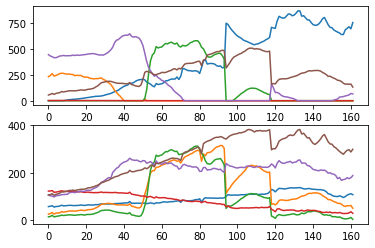

In [22]:
print('Eval criterion for A',evalCriterion(endmembers,W3_t))

fig,ax = plt.subplots(2,1)

ax[0].plot(W3_t)
ax[1].plot(endmembers)
plt.show()

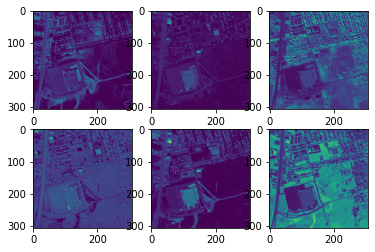

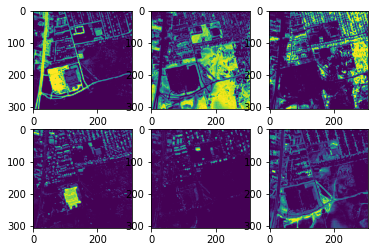

In [23]:
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(H3_t[ii,:].reshape(nCol,nRow))

plt.show()   
    
plt.figure()
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_gt[ii,:].reshape(nCol,nRow))
    
plt.show()